In [1]:
import brainpy as bp
import brainpy.math as bm
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.linalg import eig
#gridspec
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import sys
sys.path.append('..')
from cann import CANN1D

/home/zilong/anaconda3/envs/hippocampalsequence/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### set the hyper-parameters and functions

In [2]:
N = 128 #network size, i.e., number of place cells
M = 10 #truncate the number of eigenvalues, i.e., Fourier modes? 
epsilon = 1 #pertub strength, relating to the adaptation strength
offset = 10 #offset, relating to the distance between U bump and V bump

In [3]:
#generate a pertubation matrix with offset-th diagonal values equal to epsilon, other values are zero
def get_pertub_mat(N, epsilon, offset):
    '''
    get a circular matrix with offset-th diagonal values equal to epsilon, other values are zero
    N: int, the size of the matrix
    epsilon: float, the value of the offset-th diagonal
    offset: int, the offset of the diagonal
    '''
    pertub_mat = np.zeros((N, N))
    for i in range(N):
        if i+offset < N:
            pertub_mat[i, i+offset] = epsilon
        else:
            pertub_mat[i, i+offset-N] = epsilon
    return pertub_mat

def get_pertub_mat_4_visualization(N, epsilon, offset, width=5):
    '''
    get a circular matrix with offset-th diagonal values equal to epsilon, other values are zero
    N: int, the size of the matrix
    epsilon: float, the value of the offset-th diagonal
    offset: int, the offset of the diagonal
    '''
    pertub_mat = np.zeros((N, N))
    for i in range(N):
        if i+offset < N:
            pertub_mat[i, i+offset-width:i+offset+width] = epsilon
        else:
            pertub_mat[i, i+offset-width-N:i+offset+width-N] = epsilon
    return pertub_mat


### get examples of V and U bump location

Predict 10500 steps: : 100%|██████████| 10500/10500 [00:00<00:00, 20354.13it/s]
/tmp/ipykernel_2682884/198118900.py:47: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(V_t, 'r-', color='#009FB9', label='V')


(0.0, 1.2)

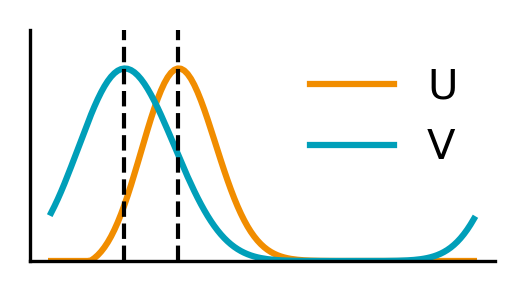

In [4]:
dt = bm.get_dt()
replay_dur = 1000      #simulate 200 ms, roughly the length of a SWR
init_dur = 50 #initial 10 ms to let the network settle

#build and run the network
#set default ramndom seed for reproducibility
#np.random.seed(123)
#set backend to cpu
bm.set_platform('cpu')

replay_cann_1 = CANN1D(tau=1., tau_v=48., num=128, mbar=5, sigma_u=0, sigma_m=0.00)
replay_cann_1.reset_state()
Iext, length = bp.inputs.section_input(
    values=[replay_cann_1.get_stimulus_by_pos(-3/4*np.pi), 0.], #initial position of the bump
    durations=[init_dur, replay_dur],
    return_length=True
)
noise = 0.00* np.random.randn(len(Iext), replay_cann_1.num) #add independent noise to the input with level 0.02
Iext = Iext + noise
Iext = bm.as_numpy(Iext)

#run the network
replay_runner_1 = bp.DSRunner(replay_cann_1,
                    inputs=('input', Iext, 'iter'),
                    monitors=['r', 'v', 'u', 'center', 'centerV'])

replay_runner_1.run(length)

U = replay_runner_1.mon.u
V = replay_runner_1.mon.v

T = 2000
U_t = U[T]
V_t = V[T]

#save U and V at time=T as a list 
np.savez('../Data/Fig8_U_V.npz', U_t=U_t, V_t=V_t)

#plot the U and V bumps at time=T
fig = plt.figure(figsize=(2, 1), dpi=300)
ax = fig.add_subplot(111)

#normalize the U and V bumps to the same height
U_t = U_t/np.max(U_t)
V_t = V_t/np.max(V_t)
ax.plot(U_t, '-', color='#F18D00', label='U')
ax.plot(V_t, 'r-', color='#009FB9', label='V')
ax.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

#find the peak
U_peak = np.argmax(U_t)
V_peak = np.argmax(V_t)
ax.axvline(U_peak, color='k', linestyle='--', linewidth=1)
ax.axvline(V_peak, color='k', linestyle='--', linewidth=1)

#ylim
ax.set_ylim([0, 1.2])

### get the displacement between U and V by varying m

Predict 10500 steps: : 100%|██████████| 10500/10500 [00:00<00:00, 25174.89it/s]


Text(0, 0.5, 'Displacement (a.u.)')

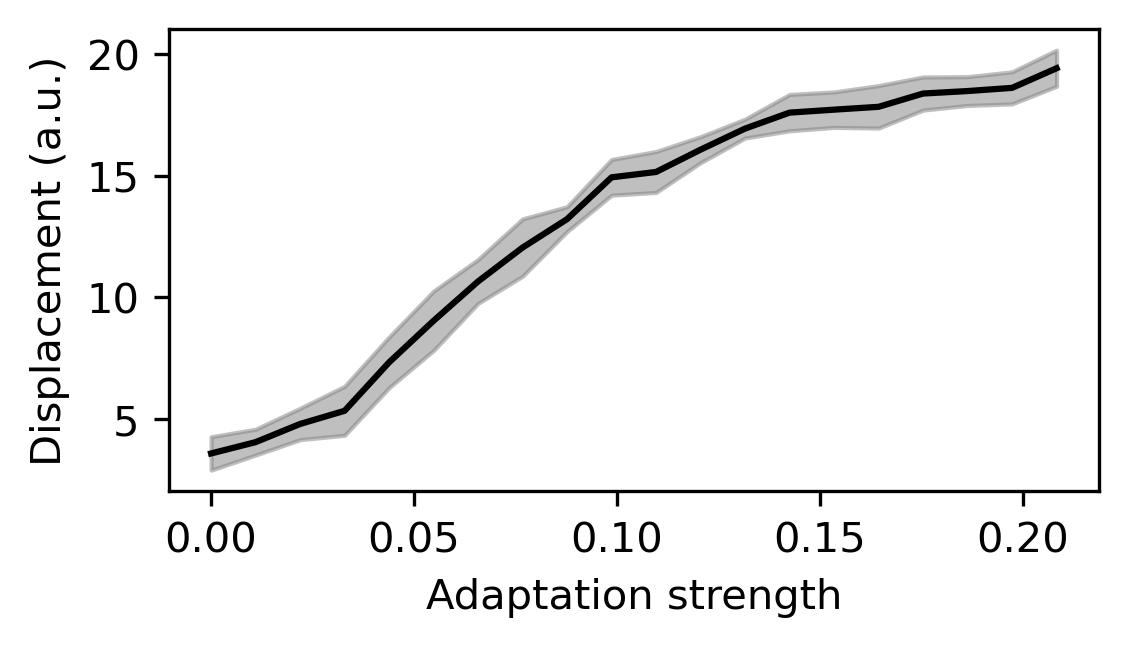

In [5]:
def get_m_d(mb):
    dt = bm.get_dt()
    replay_dur = 1000      #simulate 200 ms, roughly the length of a SWR
    init_dur = 50 #initial 10 ms to let the network settle

    #build and run the network
    #set default ramndom seed for reproducibility
    #np.random.seed(123)
    #set backend to cpu
    bm.set_platform('cpu')

    replay_cann_1 = CANN1D(tau=1., tau_v=48., num=128, mbar=mb, sigma_u=0, sigma_m=0.05)
    replay_cann_1.reset_state()
    Iext, length = bp.inputs.section_input(
        values=[replay_cann_1.get_stimulus_by_pos(-3/4*np.pi), 0.], #initial position of the bump
        durations=[init_dur, replay_dur],
        return_length=True
    )
    noise = 0.05* np.random.randn(len(Iext), replay_cann_1.num) #add independent noise to the input with level 0.02
    Iext = Iext + noise
    Iext = bm.as_numpy(Iext)

    #run the network
    replay_runner_1 = bp.DSRunner(replay_cann_1,
                        inputs=('input', Iext, 'iter'),
                        monitors=['r', 'center', 'centerV'])

    replay_runner_1.run(length)

    U_pos = replay_runner_1.mon.center
    V_pos = replay_runner_1.mon.centerV
    #get the difference between the U and V bumps
    diff = U_pos[500:] - V_pos[500:]

    #remove values (not setting to zero) in diff if the abs value is larger than 2
    new_diff = np.abs(diff[np.abs(diff)<2])
    
    adaptation_stre = replay_cann_1.m
    
    #del all variable to save memory
    del replay_cann_1, replay_runner_1,

    #print the mean of the new_diff
    return adaptation_stre, np.mean(new_diff)/2/np.pi*128

mbars = bm.linspace(0, 10, 20)

allMD = []

for repeats in range(10):
    m_d = np.zeros((20, 2))
    for i in range(20):
        mb = mbars[i]
        adap, dist = get_m_d(mb)
        m_d[i, 0] = adap
        m_d[i, 1] = dist
    allMD.append(m_d)
    
#get the mean and std of the m_d
MDnp = np.array(allMD)
#get the mean and std of the m_d
mean_dp =  np.mean(MDnp[:,:,1], axis=0)
std_dp = np.std(MDnp[:,:,1], axis=0)

adaptation_stre = MDnp[0,:,0]
#plot the mean and std of the m_d against the adaptation strength 

#save adaptation_stre, mean_dp, std_dp as a list
np.savez('../Data/Fig8_m_d.npz', adaptation_stre=adaptation_stre, mean_dp=mean_dp, std_dp=std_dp)

fig = plt.figure(figsize=(4, 2), dpi=300)
ax = fig.add_subplot(111)
ax.plot(adaptation_stre, mean_dp, 'k-', label='mean')
ax.fill_between(adaptation_stre, mean_dp-std_dp, mean_dp+std_dp, color='gray', alpha=0.5, label='std')
ax.set_xlabel('Adaptation strength')
ax.set_ylabel('Displacement (a.u.)')



### visualization of transition matrix, eigenvectors, and the relationship between m and s

/tmp/ipykernel_3389826/3428285813.py:61: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  inset_ax3.plot(V_t, 'r-', color='#009FB9', label='V', linewidth=2)
/tmp/ipykernel_3389826/3428285813.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


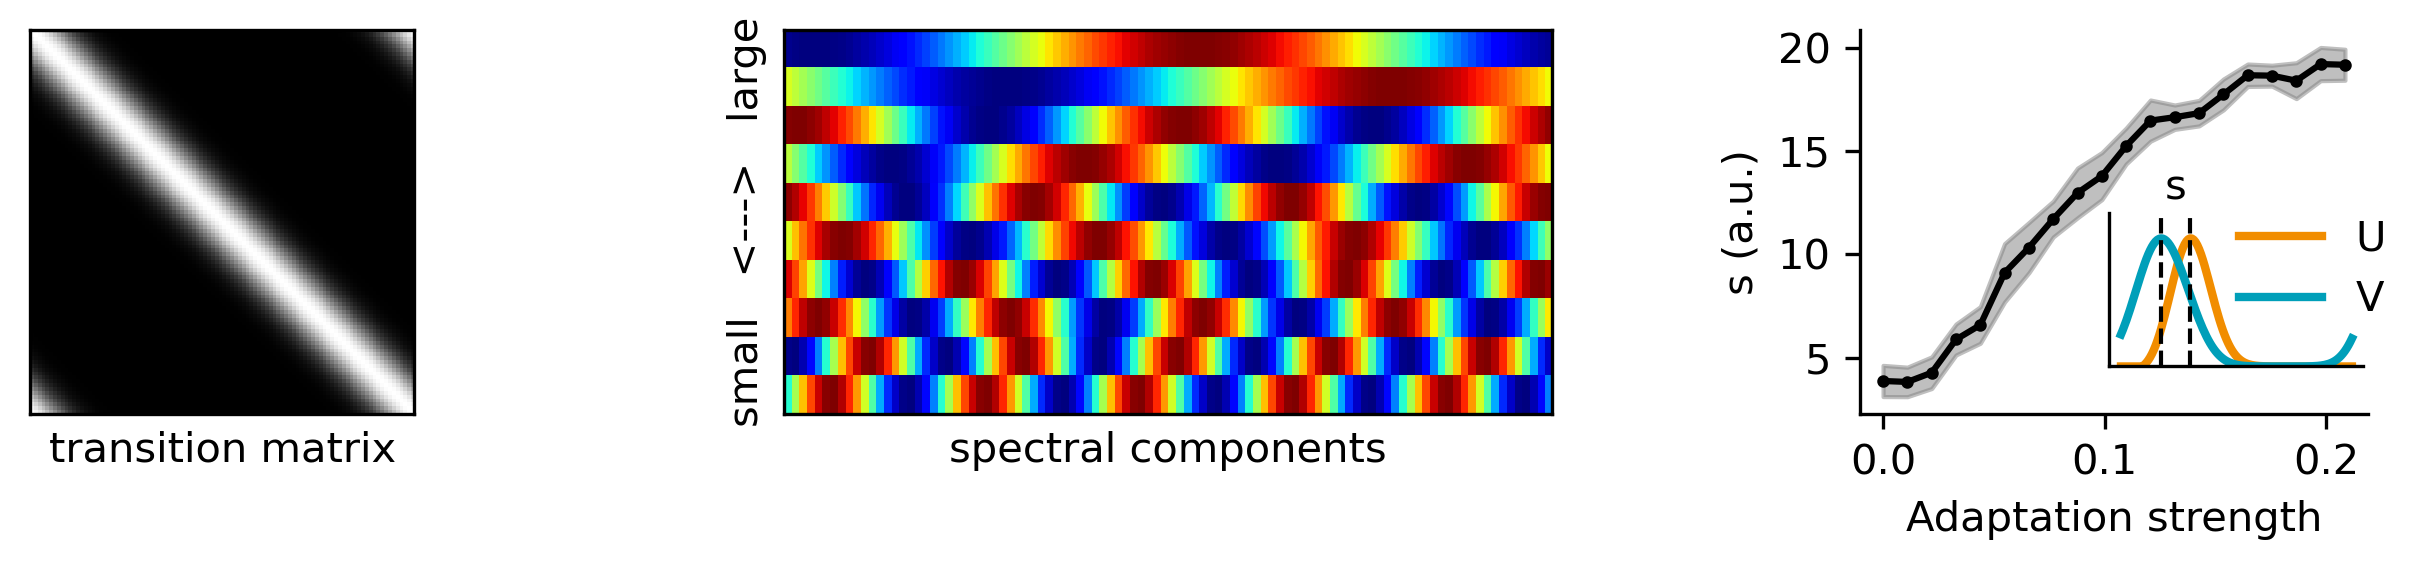

In [143]:
fig = plt.figure(figsize=(8.3, 2), dpi=300)
labelsize =10
ticksize = 8
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 2, 1])

#get the connection matrix from the CANN, i.e., the generator
replay_cann = CANN1D(tau=1., tau_v=48., num=N, mbar=1.5)

weight_mat = np.zeros((N, N))
for i in range(N):
    weight_vec = replay_cann.make_conn_i(i)
    weight_mat[i,:] = weight_vec
    
#eigendecomposition of the connection matrix
evals, evecs_l, evecs_r = eig(weight_mat, left=True, right=True)  

#plot the connection matrix
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(weight_mat, cmap='gray')
ax1.set_yticks([]); ax1.set_xticks([])
ax1.set_xlabel('transition matrix', fontsize=labelsize)
#add color bar to ax1
#cbar = plt.colorbar(ax1.imshow(weight_mat, cmap='gray'), ax=ax1, fraction=0.046, pad=0.04)

#plot the first M left eigenvectors without smoothing
#remove the first one 
ax2 = fig.add_subplot(gs[0, 1])
#imshow with the image as a squared one
ax2.imshow(evecs_l[:,1:M+1].T, cmap='jet', interpolation='none', aspect=N/M/2)
ax2.set_yticks([]); ax2.set_xticks([])
#set ylabel as large <---> small
ax2.set_ylabel('small   <--->   large', fontsize=labelsize)
ax2.set_xlabel('spectral components', fontsize=labelsize)

#plot the relation between m and s
#load the adaptation strength, mean displacement and std displacement
data = np.load('../Data/Fig8_m_d.npz')
adaptation_stre = data['adaptation_stre']
mean_dp = data['mean_dp']
std_dp = data['std_dp']
ax3 = fig.add_subplot(gs[0, 2])

ax3.plot(adaptation_stre, mean_dp, 'o-', markersize=2, color='k', markerfacecolor='k')
ax3.fill_between(adaptation_stre, mean_dp-std_dp, mean_dp+std_dp, color='gray', alpha=0.5)
ax3.set_xlabel('Adaptation strength')
ax3.set_ylabel('s (a.u.)')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

inset_ax3 = inset_axes(ax3, width='50%', height='40%', loc="lower left", 
                      bbox_to_anchor=(0.45, 0.07, 1, 1), bbox_transform=ax3.transAxes)

UV_data = np.load("../Data/Fig8_U_V.npz")
U_t = UV_data['U_t']
V_t = UV_data['V_t']

U_t = U_t/np.max(U_t)
V_t = V_t/np.max(V_t)

inset_ax3.plot(U_t, '-', color='#F18D00', label='U', linewidth=2)
inset_ax3.plot(V_t, 'r-', color='#009FB9', label='V', linewidth=2)
inset_ax3.legend(frameon=False, bbox_to_anchor=(0.8, 1.2), loc='upper center', ncol=1)
inset_ax3.spines['top'].set_visible(False)
inset_ax3.spines['right'].set_visible(False)
inset_ax3.set_xticks([])
inset_ax3.set_yticks([])

U_peak = np.argmax(U_t)
V_peak = np.argmax(V_t)
inset_ax3.axvline(U_peak, color='k', linestyle='--', linewidth=1)
inset_ax3.axvline(V_peak, color='k', linestyle='--', linewidth=1)

inset_ax3.text((U_peak+V_peak)/2, 1.3, 's', ha='center', fontsize=labelsize)
inset_ax3.set_ylim([0, 1.2])

plt.tight_layout()

plt.savefig('./Fig7_transitionmat.pdf', dpi=300)

### plot perturbation matrix

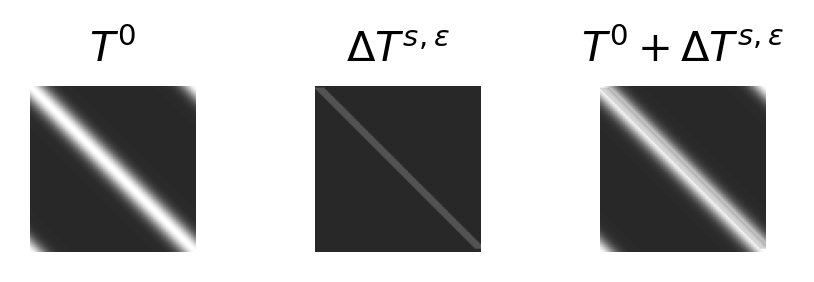

In [136]:
offset = 2

fig = plt.figure(figsize=(3, 1), dpi=300)
labelsize = 10
ticksize = 8
#gridspec.GridSpec(2, 2)
gs = gridspec.GridSpec(1, 3)

#plot the connection matrix
ax1 = fig.add_subplot(gs[0, 0])
minval = np.min(weight_mat)
maxval = np.max(weight_mat)
ax1.imshow(weight_mat, cmap='gray', vmin=minval-epsilon, vmax=maxval)
ax1.set_yticks([]); ax1.set_xticks([])
ax1.set_title(r"$T^{0}$", fontsize=labelsize)

#plot the pertubation matrix 1
ax2 = fig.add_subplot(gs[0, 1])
pertub_mat_1 = get_pertub_mat_4_visualization(N, epsilon, offset, width=3)
ax2.imshow(pertub_mat_1, cmap='gray', vmin=minval-epsilon, vmax=maxval)
ax2.set_yticks([]); ax2.set_xticks([])
ax2.set_title(r"$\Delta T^{s, \epsilon}$", fontsize=labelsize)

#subtract the pertubation matrix 1 from the connection matrix and plot
ax3 = fig.add_subplot(gs[0, 2])
ax3.imshow(weight_mat-pertub_mat_1, cmap='gray', vmin=minval-epsilon, vmax=maxval)
ax3.set_yticks([]); ax3.set_xticks([])
ax3.set_title(r"$T^{0} + \Delta T^{s, \epsilon}$", fontsize=labelsize)

#set sup title as perturbed transition matrix
#ax2.set_title('perturbation (s=%d)'%offset, fontsize=labelsize)

#set axis off
for ax in [ax1, ax2, ax3]:
    ax.axis('off')

plt.tight_layout()

#save the figure
plt.savefig('./Fig7_pertubation_%d.pdf'%offset, dpi=300)

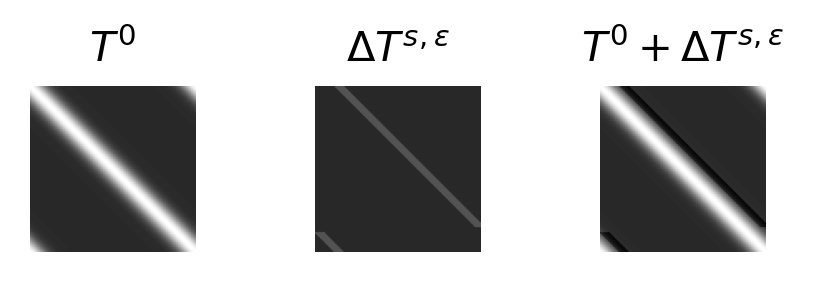

In [137]:
offset = 15
epsilon = 1

fig = plt.figure(figsize=(3, 1), dpi=300)
labelsize = 10
ticksize = 8
#gridspec.GridSpec(2, 2)
gs = gridspec.GridSpec(1, 3)

#plot the connection matrix
ax1 = fig.add_subplot(gs[0, 0])
#set colorrange to min and max of the weight matrix
minval = np.min(weight_mat)
maxval = np.max(weight_mat)
ax1.imshow(weight_mat, cmap='gray', vmin=minval-epsilon, vmax=maxval)
ax1.set_yticks([]); ax1.set_xticks([])
ax1.set_title(r"$T^{0}$", fontsize=labelsize)

#plot the pertubation matrix 1
ax2 = fig.add_subplot(gs[0, 1])
pertub_mat_1 = get_pertub_mat_4_visualization(N, epsilon, offset, width=3)
ax2.imshow(pertub_mat_1, cmap='gray', vmin=minval-epsilon, vmax=maxval)
ax2.set_yticks([]); ax2.set_xticks([])
ax2.set_title(r"$\Delta T^{s, \epsilon}$", fontsize=labelsize)

#subtract the pertubation matrix 1 from the connection matrix and plot
ax3 = fig.add_subplot(gs[0, 2])
ax3.imshow(weight_mat-pertub_mat_1, cmap='gray', vmin=minval-epsilon, vmax=maxval)
ax3.set_yticks([]); ax3.set_xticks([])
ax3.set_title(r"$T^{0} + \Delta T^{s, \epsilon}$", fontsize=labelsize)
#set sup title as perturbed transition matrix
#ax2.set_title('perturbation (s=%d)'%offset, fontsize=labelsize)

#set axis off
for ax in [ax1, ax2, ax3]:
    ax.axis('off')
    

plt.tight_layout()

#save the figure
plt.savefig('./Fig7_pertubation_%d.pdf'%offset, dpi=300)

### plot the perturbed eigenvalues

In [39]:
from spectral_analysis_utils import constructTransmat, circulant_perturbation, discrete_fourier_transform, circulantEvec, circulant_perturbation, theoretical_circulant_perturbation


/tmp/ipykernel_3389826/3276642047.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar1.set_ticklabels([0, 20, 40, 60, 80, 99])
/tmp/ipykernel_3389826/3276642047.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar2.set_ticklabels([0, 20, 40, 60, 80, 99])
/tmp/ipykernel_3389826/3276642047.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


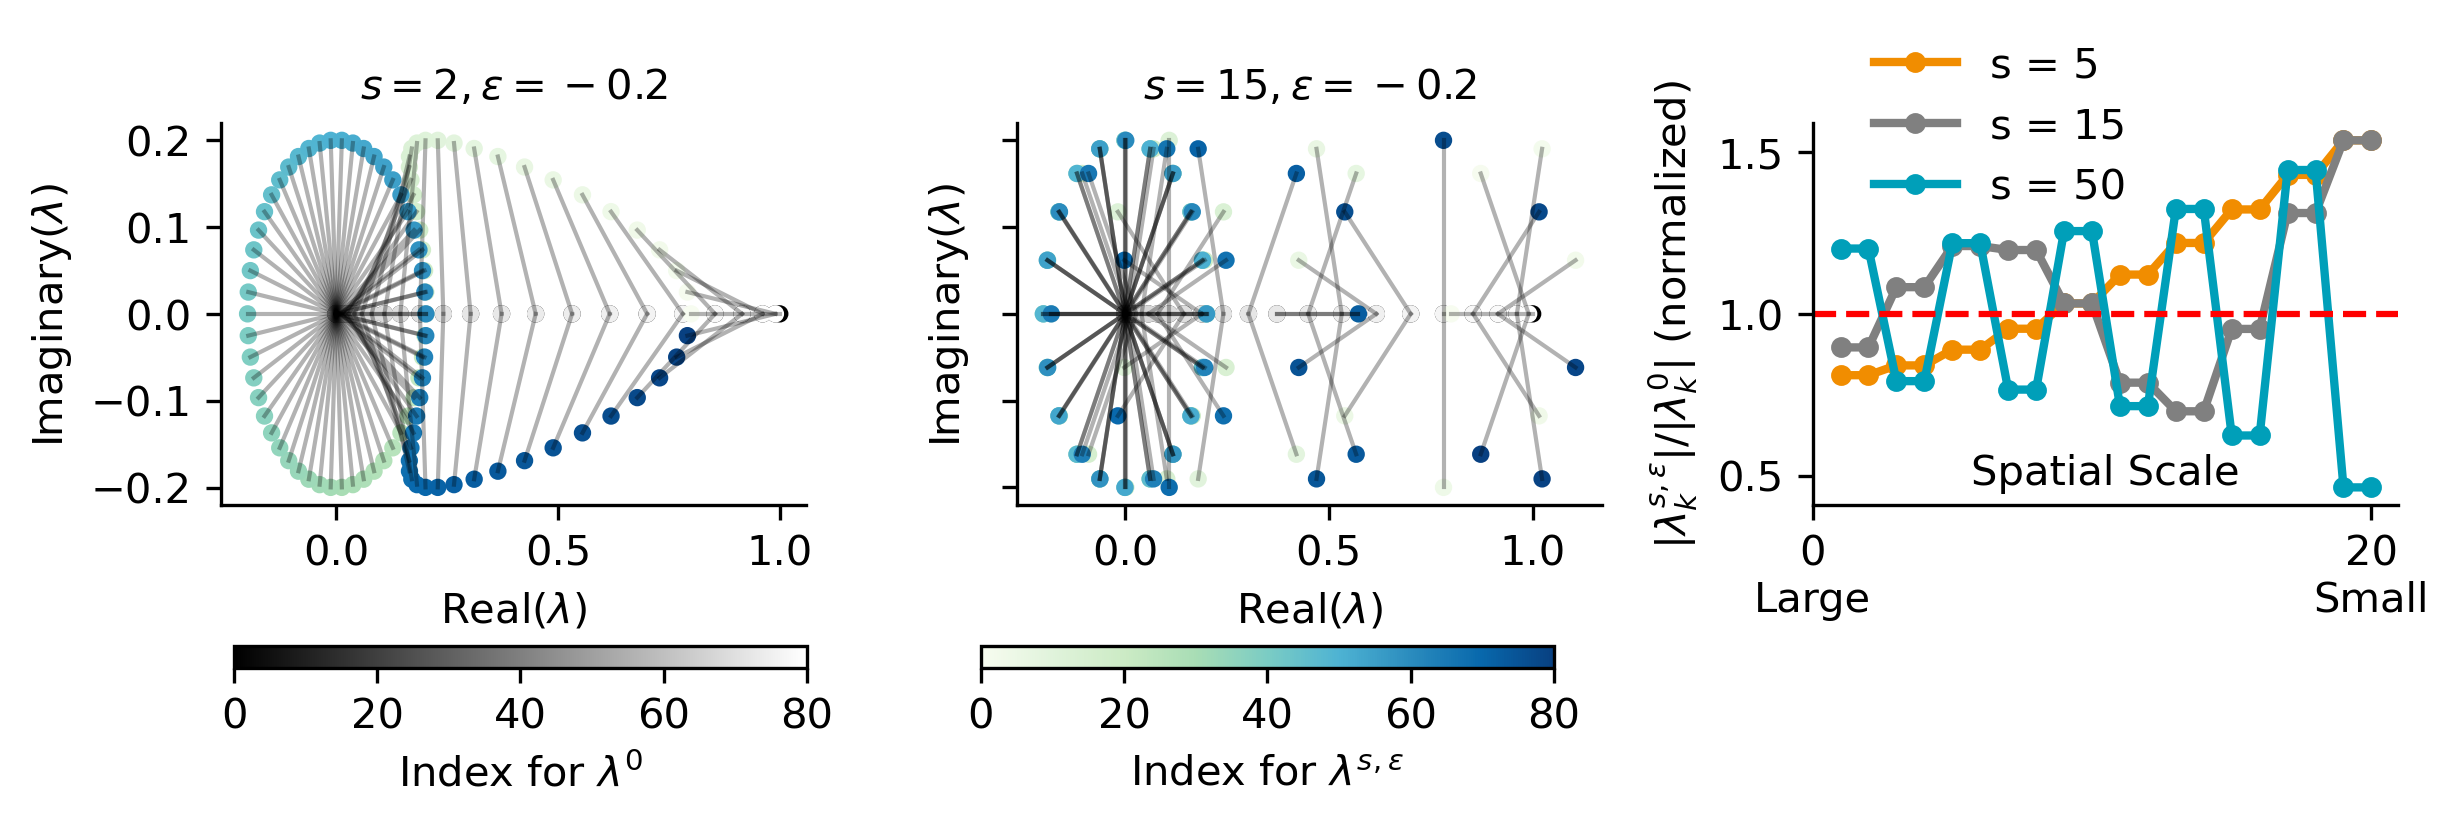

In [138]:
fig = plt.figure(figsize=(8.3, 2.5), dpi=300)
labelsize =10
ticksize = 8
outer_grid = gridspec.GridSpec(1, 3)

N = 100
var = 5
T = constructTransmat(N, 1, var)

epsilon = -0.2
evals_original = discrete_fourier_transform(T[0])
d_list = [2, 15]
colors = np.arange(N) / (N-1)

inner_grid_4 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_grid[0, :2])

for i in range(2):
    ax = plt.Subplot(fig, inner_grid_4[i])
    fig.add_subplot(ax)
    
    ax.set_title(rf"$s = {d_list[i]}, \epsilon = {epsilon}$", fontsize=labelsize)
    
    evals_perturbed_theoretical = evals_original + theoretical_circulant_perturbation(N, d_list[i], epsilon)

    scatter1 = ax.scatter(np.real(evals_original), np.imag(evals_original), c=colors, cmap="gray", label="original", s=10)
    scatter2 = ax.scatter(np.real(evals_perturbed_theoretical), np.imag(evals_perturbed_theoretical), c=colors, cmap="GnBu", label="original", s=10)


    for j in range(N):
        ax.plot([np.real(evals_original)[j], np.real(evals_perturbed_theoretical)[j]], [np.imag(evals_original)[j], np.imag(evals_perturbed_theoretical)[j]], 
                   "k-", alpha=0.3, linewidth=1)
    
    ax.set_xlabel(r"Real($\lambda$)", fontsize=labelsize)

    ax.set_ylabel(r"Imaginary($\lambda)$", fontsize=labelsize)
    
    ax.set_yticks(np.arange(-0.2, 0.21, 0.1))
    
    if i == 1:
        ax.set_yticklabels([])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

cbar_ax1 = fig.add_axes([0.1, 0.01, 0.23, 0.03])
cbar_ax2 = fig.add_axes([0.4, 0.01, 0.23, 0.03])

cbar1 = fig.colorbar(scatter1, cax=cbar_ax1, orientation="horizontal")
cbar1.set_label(r'Index for $\lambda^{0}$', fontsize=labelsize)
cbar2 = fig.colorbar(scatter2, cax=cbar_ax2, orientation="horizontal")
cbar2.set_label(r'Index for $\lambda^{s, \epsilon}$', fontsize=labelsize)

cbar1.set_ticklabels([0, 20, 40, 60, 80, 99])
cbar2.set_ticklabels([0, 20, 40, 60, 80, 99])


#panel 3
# panel e
ax = plt.Subplot(fig, outer_grid[0, 2])
fig.add_subplot(ax)

inds = np.argsort(np.abs(evals_original))[::-1]

colors = ['#F18D00', 'gray', '#009FB9']
for d in [5, 15, 50]:
    evals_perturbed_theoretical = evals_original + theoretical_circulant_perturbation(N, d, epsilon)
    ax.plot(np.arange(1, 21), (np.abs(evals_perturbed_theoretical) / np.abs(evals_original))[inds][1:21], "o-", label=f"s = {d}", 
             linewidth=2, markersize=4, color=colors.pop(0))

ax.legend(fontsize=labelsize, frameon=False, bbox_to_anchor=(0.6, 1.3))
ax.set_xticks([0, 20], ["0\nLarge", "20\nSmall"], fontsize=labelsize)
ax.axhline(1.0, linestyle="--", color="red")
ax.set_xlabel("Spatial Scale", labelpad=-40, fontsize=labelsize)
ax.set_ylabel(r"$|\lambda_{k}^{s, \epsilon}| / |\lambda^{0}_{k}|$ (normalized)", fontsize=labelsize)
#keep 1 decimal of yticks
ax.set_yticks([0.5,1,1.5])

ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)

plt.tight_layout()

plt.savefig('./Fig7_eigenvalues.pdf', dpi=300)
